In [2]:
import numpy as np
import os
from scipy.linalg import schur
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import n_fixed_points as fp
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
def calc_norm(A):
    return np.sqrt(np.sum(A**2,axis=0))
    
def demean(s):
    return s-np.mean(s,axis=0)

def relu(s):
    return np.maximum(s,0)

def gen_angle(W,U):
    normW = calc_norm(W)
    normU = calc_norm(U)
    return np.arccos(np.clip((W.T.dot(U))/np.outer(normW,normU),-1.,1.))

def get_accuracy(data,s,w):
    target = np.argmax(data[1][:,-1,:],axis=1)
    output = relu(s).dot(w['W_out'].T) + w['b_out']
    resp = np.argmax(output[-1,:,:],axis=1)
    
    return np.mean(resp==target)

def run_trial_batch(data,w,sim):
    s = np.zeros([data[0].shape[1],data[0].shape[0],w['W_rec'].shape[0]])
    for kk in range(data[0].shape[0]):
        s[:,kk,:] = sim.run_trial(data[0][kk,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],w['W_rec'].shape[0]])
        
    return s

def kalman_rank_condition(Win,Wrec):
    '''Determine whether a matrix Wrec is controllable with an input matrix Win.'''
    
    kalman_matrix = Win
    for ii in range(1,Wrec.shape[0]):
        kalman_matrix = np.hstack([kalman_matrix, np.linalg.matrix_power(Wrec,ii).dot(Win)]) 
    
    rank = np.linalg.matrix_rank(kalman_matrix)
    return rank==Wrec.shape[0]

def controllable_partitions(Win,Wrec):
    '''Calculate the percentage of controllable partitions for a ReLU Network.'''
    
    import itertools as it

    partitions = it.product([0,1],repeat=Wrec.shape[0])
    controllability = np.zeros(2**Wrec.shape[0])
    for ii,part in enumerate(partitions):
        controllability[ii] = kalman_rank_condition(Win,Wrec.dot(np.diag(np.asarray(part))))

    return np.mean(controllability)

In [4]:
    
    #run params
    run_tag = 'demo_notebook_n50_2_'
    task = 'fixed_point'
    
    save_directory = '/Users/daniel/Documents/de244/code/git/sisyphus2/network_output/' + task + '_' + run_tag 
    # script_directory = save_directory + '/' + task + '_' + run_tag + '_scripts'
    fig_directory = save_directory + '/' + task + '_' + run_tag + '_figs'
    save_weights_directory = '/Users/daniel/Documents/de244/code/git/sisyphus2/weights/' + task + '_' + run_tag
    save_weights_path = save_weights_directory + '/' + run_tag + '.npz'

    try:
        os.stat(save_directory)
    except:
        os.mkdir(save_directory)

    try:
        os.stat(fig_directory)
    except:
        os.mkdir(fig_directory)

    try:
        os.stat(save_weights_directory)
    except:
        os.mkdir(save_weights_directory)

    n_in = n_out = 4
    n_rec = 50

    #model params
    #n_in = n_out = 5 #number of fixed points
    #n_rec = 10 
    #n_steps = 80 
    tau = 100.0 #As double
    dt = 20.0  #As double
    dale_ratio = 0
    rec_noise = .01
    stim_noise = 0.1
    batch_size = 128 #256
    #var_delay_length = 50

    n_back = 0

    #train params
    learning_rate = .0001 
    training_iters = 150000
    display_step = 20
    
    #periodic save params
    training_weights_path = save_weights_path[:-4]
    weight_save_step = 2


    params = fp.set_params(n_in = n_in, n_out = n_out, n_steps = 300, stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, L2_firing_rate = 0,
                    sample_size = 128, epochs = 100, N_rec = n_rec, dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_fixed')
    generator = fp.generate_train_trials(params)
    #model = Model(n_in, n_hidden, n_out, n_steps, tau, dt, dale_ratio, rec_noise, batch_size)


In [4]:
    model = Model(params)
    sess = tf.Session()


    model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters, batch_size=batch_size,
                save_weights_path = save_weights_path, display_step=display_step,
                training_weights_path=training_weights_path,weight_save_step=weight_save_step)

Iter 2560, Minibatch Loss= 0.197377
Iter 5120, Minibatch Loss= 0.194965
Iter 7680, Minibatch Loss= 0.190137
Iter 10240, Minibatch Loss= 0.178159
Iter 12800, Minibatch Loss= 0.154139
Iter 15360, Minibatch Loss= 0.153243
Iter 17920, Minibatch Loss= 0.151032
Iter 20480, Minibatch Loss= 0.150741
Iter 23040, Minibatch Loss= 0.148719
Iter 25600, Minibatch Loss= 0.144958
Iter 28160, Minibatch Loss= 0.142632
Iter 30720, Minibatch Loss= 0.124769
Iter 33280, Minibatch Loss= 0.111545
Iter 35840, Minibatch Loss= 0.114191
Iter 38400, Minibatch Loss= 0.104058
Iter 40960, Minibatch Loss= 0.104531
Iter 43520, Minibatch Loss= 0.103290
Iter 46080, Minibatch Loss= 0.104014
Iter 48640, Minibatch Loss= 0.088660
Iter 51200, Minibatch Loss= 0.088282
Iter 53760, Minibatch Loss= 0.081003
Iter 56320, Minibatch Loss= 0.077392
Iter 58880, Minibatch Loss= 0.068994
Iter 61440, Minibatch Loss= 0.067242
Iter 64000, Minibatch Loss= 0.060110
Iter 66560, Minibatch Loss= 0.057944
Iter 69120, Minibatch Loss= 0.054184
Iter

330.3336298465729

In [5]:
# len(os.listdir(save_weights_directory))
w = np.load(training_weights_path+'40'+'.npz')
w['W_in'].shape

(50, 4)

In [6]:
steps = training_iters/batch_size
xx = range(weight_save_step,steps,weight_save_step)
print len(xx)
w_recs = np.zeros([n_rec,n_rec,len(xx)])
w_ins = np.zeros([n_rec,n_in,len(xx)])
w_outs = np.zeros([n_out,n_rec,len(xx)])

b_recs = np.zeros([n_rec,len(xx)])
b_outs = np.zeros([n_out,len(xx)])

for ii,jj in enumerate(xx):

    w = np.load(training_weights_path+str(jj)+'.npz')
    w_recs[:,:,ii] = w['W_rec']
    w_ins[:,:,ii] = w['W_in']
    w_outs[:,:,ii] = w['W_out']
    
    b_recs[:,ii] = w['b_rec']
    b_outs[:,ii] = w['b_out']

585


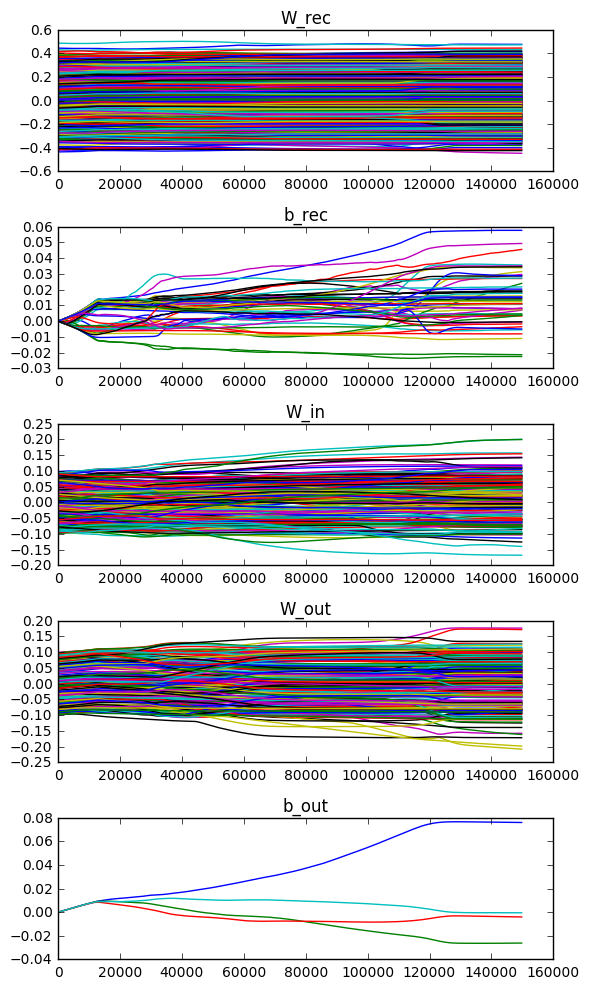

In [7]:
plt.figure(figsize=(6,10))

plt.subplot(5,1,1)
plt.plot(batch_size*np.array(xx),w_recs.reshape(n_rec**2,len(xx)).T,alpha=1)
plt.title('W_rec')

plt.subplot(5,1,2)
plt.plot(batch_size*np.array(xx),b_recs.T)
plt.title('b_rec')

plt.subplot(5,1,3)
plt.plot(batch_size*np.array(xx),w_ins.reshape(n_rec*n_in,len(xx)).T,alpha=1)
plt.title('W_in')

plt.subplot(5,1,4)
plt.plot(batch_size*np.array(xx),w_outs.reshape(n_rec*n_out,len(xx)).T,alpha=1)
plt.title('W_out')

plt.subplot(5,1,5)
plt.plot(batch_size*np.array(xx),b_outs.T)
plt.title('b_out')



plt.tight_layout()
plt.show()

(4, 50, 585)


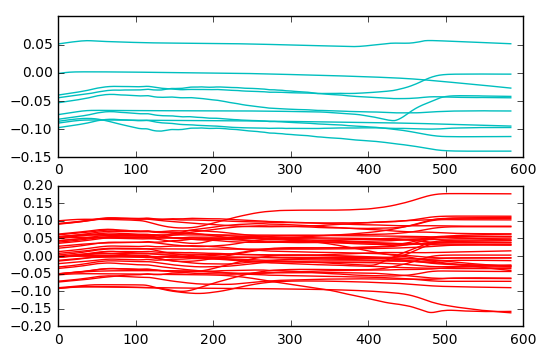

In [8]:
print w_outs.shape
plt.subplot(2,1,1)
plt.plot(w_outs[0,b_recs[:,-1]<0,:].T,'c')
plt.subplot(2,1,2)
plt.plot(w_outs[0,b_recs[:,-1]>0,:].T,'r')
plt.show()

In [9]:
updates = np.zeros([n_rec**2,len(xx)])

# plt.figure(figsize=(10,10))
for ii in range(1,len(xx)):
    updates[:,ii] = (w_recs[:,:,ii]-w_recs[:,:,ii-1]).flatten()
#     plt.subplot(len(xx)/5+1,5,ii)
#     plt.imshow(w_recs[:,:,ii]-w_recs[:,:,ii-1],interpolation='none',vmin=-.005,vmax=.005)
#     plt.colorbar()

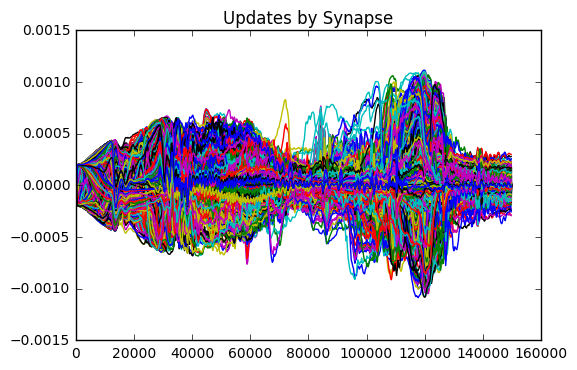

In [10]:
plt.plot(batch_size*np.array(xx),updates.T)
plt.title('Updates by Synapse')
plt.show()

(2500, 100)


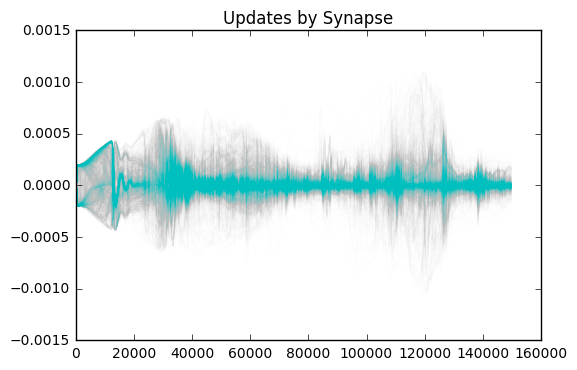

In [11]:
print updates[:,:100].shape
plt.plot(batch_size*np.array(xx[:]),updates[:,:].T,'c',alpha=.005)
plt.title('Updates by Synapse')
plt.show()

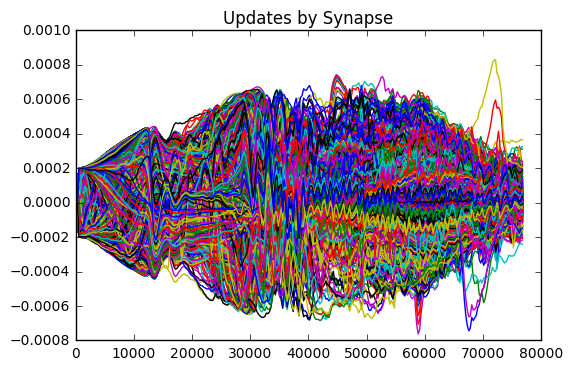

In [12]:
# print updates[:,:100].shape
plt.plot(batch_size*np.array(xx[:300]),updates[:,:300].T)
plt.title('Updates by Synapse')
plt.show()

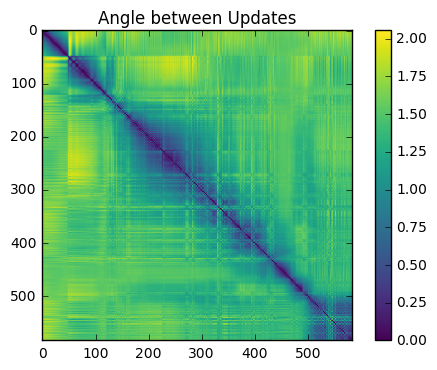

(2500, 585)


In [13]:
angles = gen_angle(updates[:,1:],updates[:,1:])
plt.imshow(angles,interpolation='none')
plt.colorbar()
plt.title('Angle between Updates')
plt.show()

print updates.shape

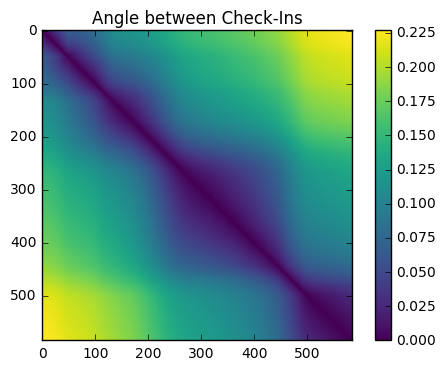

In [14]:
w_recs_flat = w_recs.reshape(n_rec**2,len(xx))
angles = gen_angle(w_recs_flat,w_recs_flat)
plt.imshow(angles,interpolation='none')
plt.colorbar()
plt.title('Angle between Check-Ins')
plt.show()

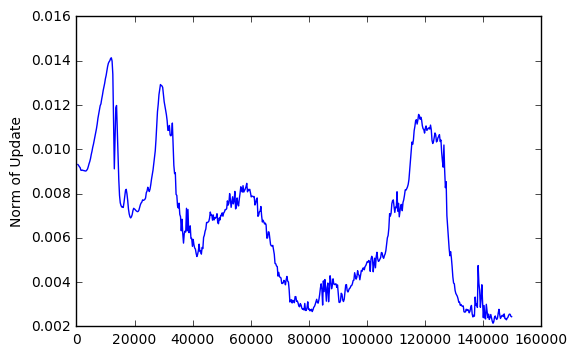

In [15]:
update_norm = np.sqrt(np.sum(updates**2,axis=0))[1:]
plt.plot(batch_size*np.array(xx)[1:],np.sqrt(np.sum(updates**2,axis=0))[1:])
plt.ylabel('Norm of Update')
plt.show()

In [62]:
n_reps = 200
temp = np.zeros(n_reps)

num_on = 46
partition_set = np.zeros(w_recs.shape[0])
partition_set[:num_on] = 1.

for ii in range(n_reps):
    partition = np.random.permutation(partition_set)
    temp[ii] = kalman_rank_condition(w_ins[:,:,0],w_recs[:,:,0].dot(np.diag(partition)))
print np.mean(temp)

1.0


/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


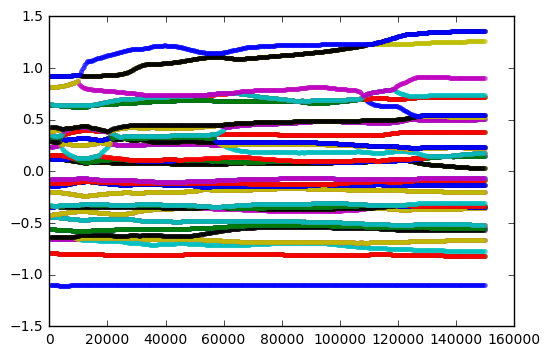

In [18]:
evals = np.zeros([w_recs.shape[0],w_recs.shape[2]])
for ii in range(w_recs.shape[2]):
    evals[:,ii] = np.sort(np.linalg.eig(w_recs[:,:,ii])[0])
    
plt.plot(batch_size*np.array(xx),evals.T,'.',alpha=0.4)
plt.show()

In [17]:

source = training_weights_path+str(xx[-1])+'.npz'
w = np.load(source)
params['sample_size'] = 1000
sim = Simulator(params, weights_path=source)

accuracy: 100.0 %


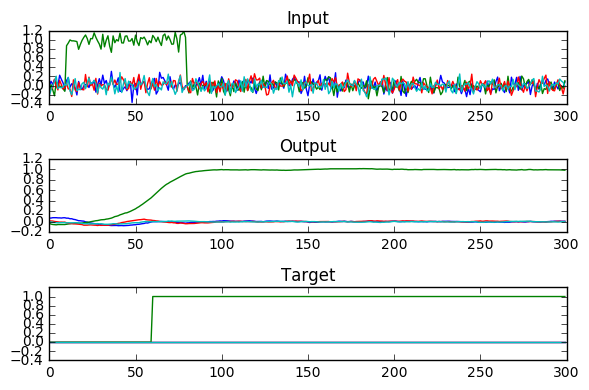

In [18]:
data = generator.next()
s = run_trial_batch(data,w,sim)
print 'accuracy: ' + str(get_accuracy(data,s,w)*100) + ' %'

trial = 4

plt.subplot(3,1,1)
plt.plot(data[0][trial,:,:])
plt.title('Input')
plt.subplot(3,1,2)
plt.plot(relu(s[:,trial,:]).dot(w['W_out'].T) + w['b_out'])
plt.title('Output')
plt.subplot(3,1,3)
plt.plot(data[1][trial,:,:])
plt.title('Target')
plt.ylim([-.4,1.2])

plt.tight_layout()
plt.show()

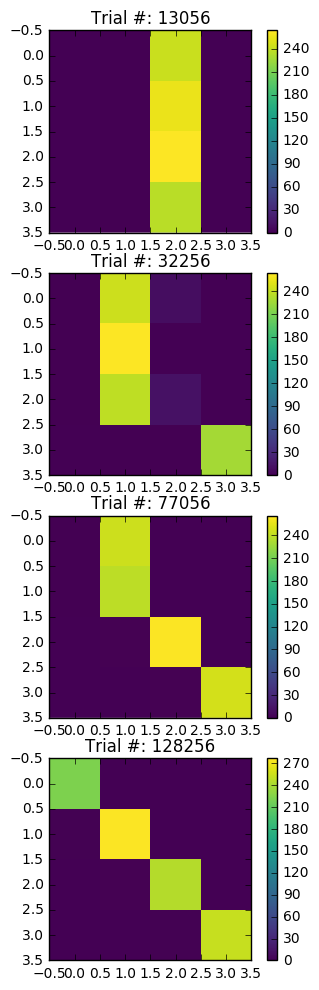

In [38]:
'''confusion matrix'''

break_points = [50,125,300,500]

plt.figure(figsize=(4,12))
count = 1

for bp in break_points:

    source = training_weights_path+str(xx[bp])+'.npz'
    w = np.load(source)
    params['sample_size'] = 1000
    sim = Simulator(params, weights_path=source)

    data = generator.next()
    s = run_trial_batch(data,w,sim)

    target = np.argmax(data[1][:,-1,:],axis=1)
    output = relu(s).dot(w['W_out'].T) + w['b_out']
    resp = np.argmax(output[-1,:,:],axis=1)

    conf_mat = np.zeros([n_in,n_in])
    for ii in range(n_in):
        for jj in range(n_in):
            conf_mat[ii,jj] = np.sum(np.logical_and(target==ii,resp==jj))


    plt.subplot(4,1,count)
    plt.imshow(conf_mat,interpolation='none')
    plt.title('Trial #: ' + str(xx[bp]*batch_size))
    plt.colorbar()
    
    count+=1
plt.show()

In [39]:
t0 = time.time()

skip_step = 2
params['sample_size'] = 128

idx = range(0,len(xx),skip_step)

acc = np.zeros(len(idx)) #xx is the array of save steps

count = 0
for ii in idx:
    source = training_weights_path+str(xx[ii])+'.npz'
    w = np.load(source)
    data = generator.next()
    sim = Simulator(params, weights_path=source)
    
    s = run_trial_batch(data,w,sim)
    acc[count] = get_accuracy(data,s,w)
    
    if np.mod(count,5) == 0:
        print count,ii,xx[ii],acc[count]
        
    count+=1
    
t1 = time.time()
total = t1-t0
print total

0 0 2 0.21875
5 10 22 0.2890625
10 20 42 0.3203125
15 30 62 0.2265625
20 40 82 0.21875
25 50 102 0.2890625
30 60 122 0.25
35 70 142 0.1875
40 80 162 0.25
45 90 182 0.2265625
50 100 202 0.25
55 110 222 0.2265625
60 120 242 0.4609375
65 130 262 0.5
70 140 282 0.5625
75 150 302 0.515625
80 160 322 0.640625
85 170 342 0.7265625
90 180 362 0.75
95 190 382 0.7890625
100 200 402 0.796875
105 210 422 0.625
110 220 442 0.71875
115 230 462 0.765625
120 240 482 0.7578125
125 250 502 0.8203125
130 260 522 0.7109375
135 270 542 0.75
140 280 562 0.7265625
145 290 582 0.8203125
150 300 602 0.8046875
155 310 622 0.7265625
160 320 642 0.765625
165 330 662 0.7578125
170 340 682 0.765625
175 350 702 0.7890625
180 360 722 0.8203125
185 370 742 0.75
190 380 762 0.7265625
195 390 782 0.734375
200 400 802 0.7578125
205 410 822 0.734375
210 420 842 0.765625
215 430 862 0.9375
220 440 882 1.0
225 450 902 1.0
230 460 922 1.0
235 470 942 1.0
240 480 962 1.0
245 490 982 1.0
250 500 1002 1.0
255 510 1022 1.0
260 5

1170


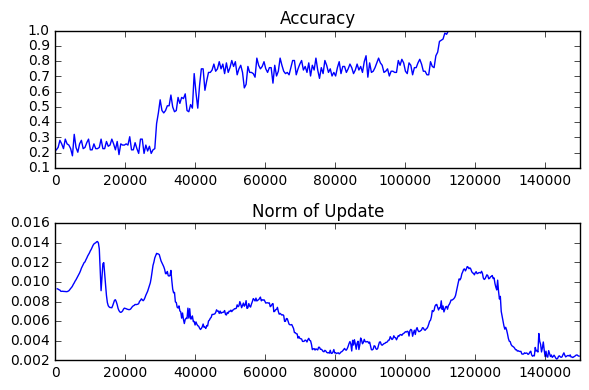

In [40]:
# print temp_xx
# print acc
print xx[-1]
plt.subplot(2,1,1)
plt.plot(np.array(xx)[idx]*batch_size,acc)
plt.xlim([0,1.5e5])
plt.title('Accuracy')
plt.subplot(2,1,2)
plt.plot(batch_size*np.array(xx)[1:],np.sqrt(np.sum(updates**2,axis=0))[1:])
plt.xlim([0,1.5e5])
plt.title('Norm of Update')

plt.tight_layout()
plt.show()

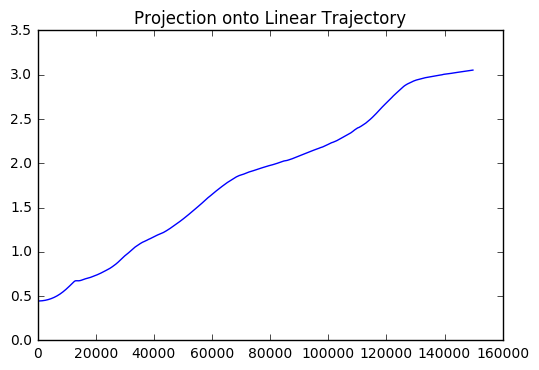

In [41]:
'''linear trajectory'''

m = w_recs_flat[:,-1] - w_recs_flat[:,0]
plt.plot(batch_size*np.array(xx),m.dot(w_recs_flat))
plt.title('Projection onto Linear Trajectory')
plt.show()

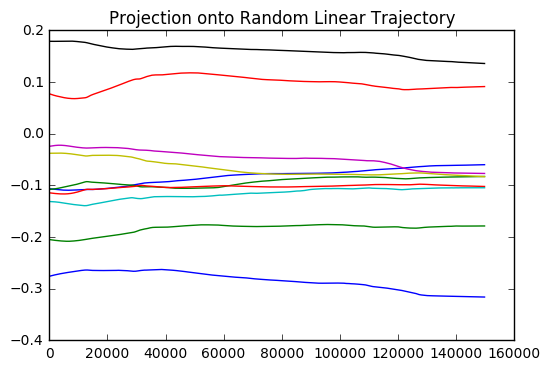

In [44]:
'''random linear projections'''

q = np.linalg.qr(np.random.randn(updates.shape[0],10))[0]

plt.plot(batch_size*np.array(xx),q.T.dot(w_recs_flat).T)
plt.title('Projection onto Random Linear Trajectory')
plt.show()

In [ ]:
len(xx)